In [203]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import re
import numpy as np
from collections import Counter
import datetime
plt.style.use('ggplot')
from matplotlib import style
import csv
import os
import numpy
import copy
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import NMF, PCA
import matplotlib as mpl
from collections import Counter, defaultdict, OrderedDict
from gensim import corpora, models, similarities, matutils
from gensim.corpora.dictionary import Dictionary
from pandas import DataFrame, Series
import matplotlib

import operator
from operator import itemgetter


%matplotlib inline
dataset = pd.read_csv("/Users/fayikanova/Desktop/tweets1/tweets.csv", parse_dates=['time'], infer_datetime_format=True)







In [204]:
def tsimple(x):
    return datetime.datetime(x.year, x.month, x.day)

dataset['time'] = dataset.time.apply(tsimple)

Unique tweets: 17410
All tweets: 17410
unique users:17410


[Text(0, 0, 'Actual Tweets'), Text(0, 0, 'Retweets')]

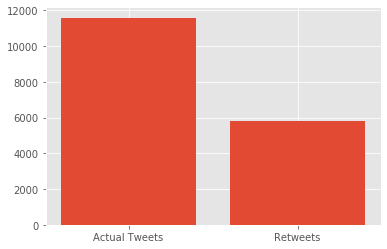

In [236]:
print("Unique tweets: {}".format(len(dataset['tweets'].unique())))
print("All tweets: {}".format(len(dataset['tweets'])))
print("unique users:{}".format(len(dataset['username'])))

retweets = []
actual_tweets = []
for user, tweet in zip(dataset['username'], dataset['tweets']):
    match = re.search(r'^\bRT\b', tweet)
    if match == None:
        actual_tweets.append([user,tweet])
    else:
        retweets.append([user,tweet])   

actual_tweets = np.array(actual_tweets)
retweets = np.array(retweets)

plt.bar([1,2], [len(actual_tweets[:,1]), len(retweets[:,1])], align='center')
ax = plt.gca()
ax.set_xticks([1,2])
ax.set_xticklabels(['Actual Tweets', 'Retweets'])

Text(0.5, 1.0, 'Mentioned vs. Total in tweets.csv')

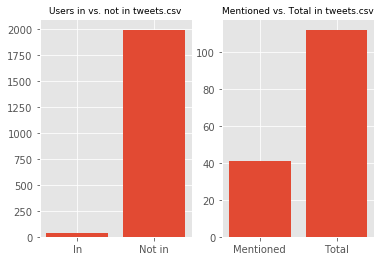

In [219]:
in_set = []
not_in_set = []
for record in actual_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if (name[1:] in dataset['username'].unique()) and (record[0] != name[1:]):
                in_set.append([record[0], name[1:]])
            elif record[0] != name[1:]:
                not_in_set.append([record[0], name[1:]])

in_set = np.array(in_set)
not_in_set = np.array(not_in_set)

fig, ax = plt.subplots(1,2)

ax[0].bar([1,2], [len(np.unique(in_set[:,1])), len(np.unique(not_in_set[:,1]))], align='center')
ax[0].set_xticks([1,2])
ax[0].set_xticklabels(['In', 'Not in'])
ax[0].set_title('Users in vs. not in tweets.csv', fontsize=9)

ax[1].bar([1,2], [len(np.unique(in_set[:,1])), len(dataset['username'].unique())], align='center')
ax[1].set_xticks([1,2])
ax[1].set_xticklabels(['Mentioned', 'Total'])
ax[1].set_title('Mentioned vs. Total in tweets.csv', fontsize=9)

In [220]:
sender_count = Counter(in_set[:,0])
receiver_count = Counter(in_set[:,1])
top_5_senders = sender_count.most_common(5)
top_5_receivers = receiver_count.most_common(5)

print(top_5_senders)
print(top_5_receivers)

[('MaghrabiArabi', 49), ('WarReporter1', 30), ('AsimAbuMerjem', 27), ('Uncle_SamCoco', 27), ('moustiklash', 20)]
[('RamiAlLolah', 53), ('Nidalgazaui', 34), ('MilkSheikh2', 26), ('WarReporter1', 15), ('_IshfaqAhmad', 15)]


In [221]:
for name, _ in top_5_receivers:
    print("Username: {} - {}\n".format(name,
            dataset[dataset['username'] == name]['description'].dropna().unique()[0]))

Username: RamiAlLolah - Real-Time News, Exclusives, Intelligence & Classified Information/Reports from the ME. Forecasted many Israeli strikes in Syria/Lebanon. Graphic content.

Username: Nidalgazaui - 17yr. old Freedom Activist
/Correspondence of NGNA /Terror Expert/Middle East Expert. Daily News about Syria/Iraq/Yemen/Russia/Middle East

Username: MilkSheikh2 - Muslim, Iraqi, Banu Zubid, Qahtani, Chef, Engineer, Remaining until the best of them, fights al-Dajjal, Translate Old stuff mostly

Username: WarReporter1 - Reporting on conflicts in the MENA and Asia regions.

Username: _IshfaqAhmad - Medico at GMC Srinagar • Pro-Khilafah • Anti-Democratic • Anti-Nationalistic • Anti-Rafidah • Innocent Bystander of the Conflict in Middle East • Cricketist •



In [222]:
graph = nx.Graph()

all_users = list(set(in_set[:,0]) | set(in_set[:,1]))
graph.add_nodes_from(all_users, count=10)
node_colours = []

for node in graph.nodes():
    if node in (set(in_set[:,0]) & set(in_set[:,1])):
        node_colours.append('g')
    elif node in np.unique(in_set[:,0]):
        node_colours.append('r')
    elif node in np.unique(in_set[:,1]):
        node_colours.append('b')

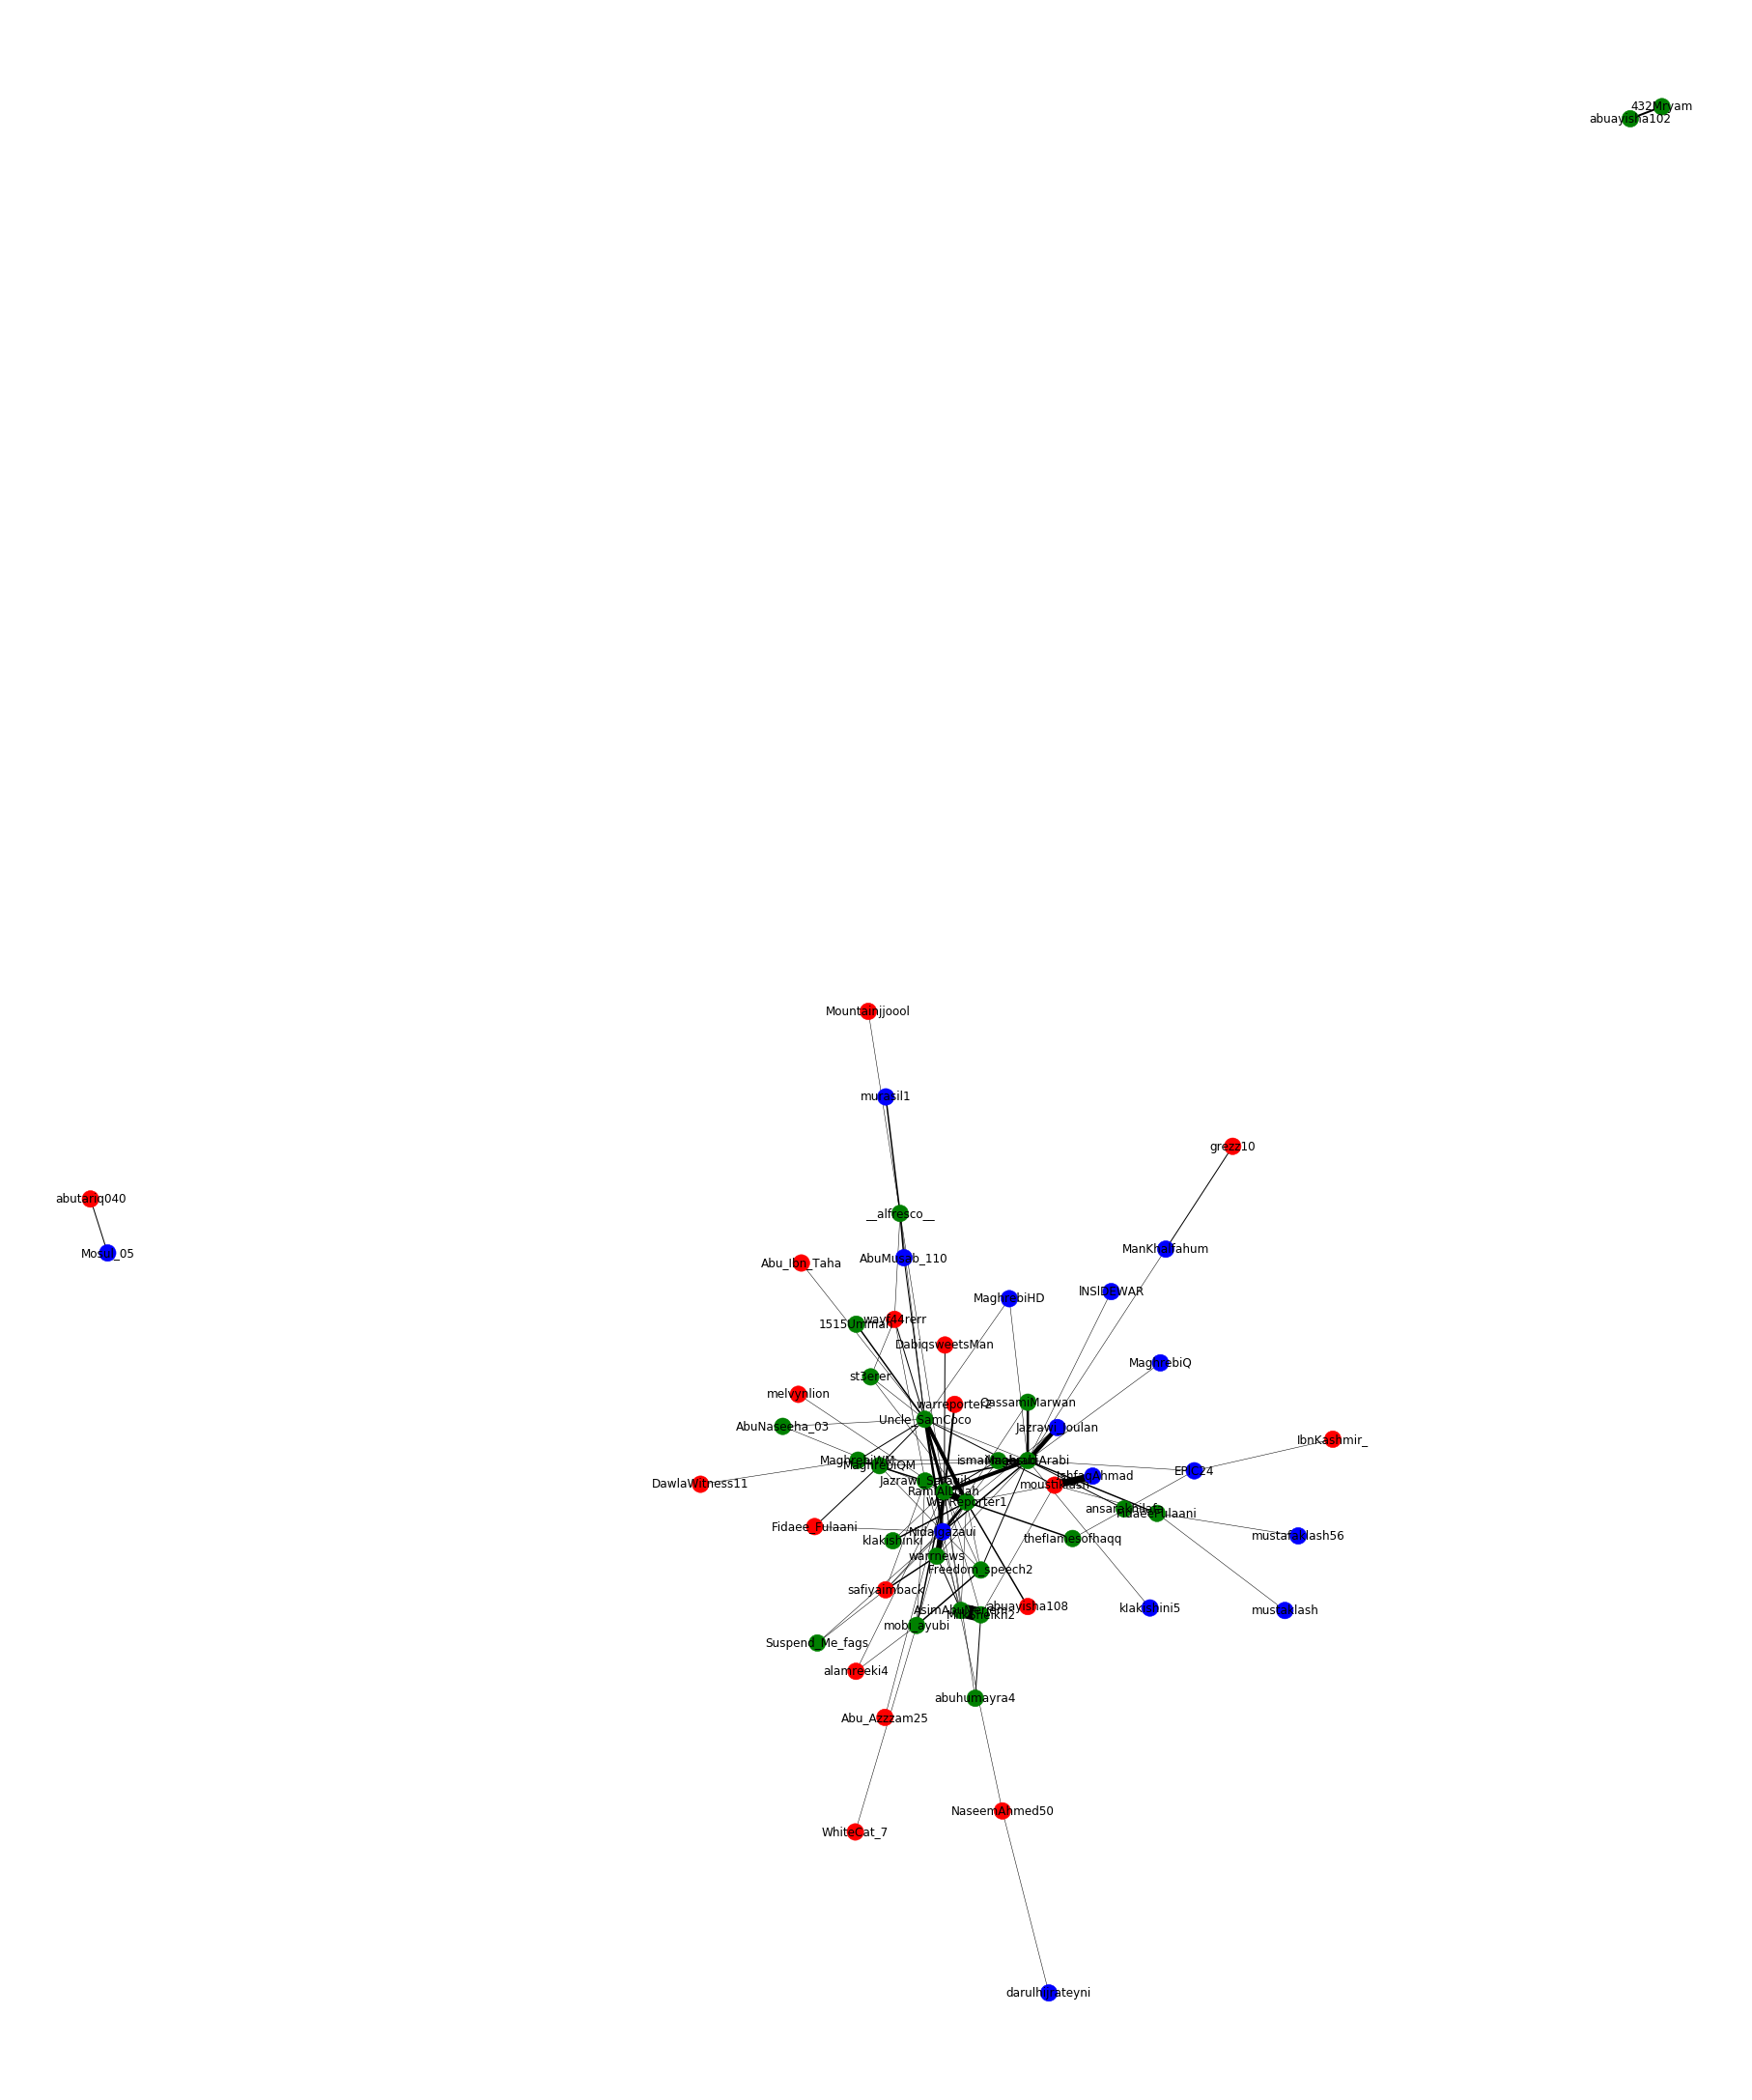

In [224]:
edges = {}
occurrence_count = Counter(map(tuple, in_set))
for (sender, receiver), count in occurrence_count.items():
    if (receiver, sender) in edges.keys():
        edges[(receiver, sender)] = edges[(receiver, sender)] + count
    else:
        edges[(sender, receiver)] = count
        
for (sender, receiver), count in edges.items():
    graph.add_edge(sender, receiver, weight=count)
    
followers = {}
tweet_num = {}
for username in all_users:
    followers[username] = dataset[dataset['username'] == username]['followers'].unique()[-1]
    tweet_num[username] = dataset[dataset['username'] == username]['tweets'].count()

sizes = [(followers[n] / tweet_num[n]) * 50 for n in graph.nodes()]

weights = [graph[u][v]['weight']/2 for u, v in graph.edges()]

plt.figure(figsize=(25,30))
nx.draw(graph, pos=nx.spring_layout(graph),
        node_color=node_colours, with_labels=True, width=weights)
plt.show()


In [225]:
degree_dict = dict(graph.degree(graph.nodes()))
nx.set_node_attributes(graph, degree_dict, 'degree')

In [226]:
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [227]:
print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
('RamiAlLolah', 19)
('MaghrabiArabi', 19)
('Uncle_SamCoco', 16)
('WarReporter1', 14)
('Nidalgazaui', 14)
('Jazrawi_Saraqib', 8)
('warrnews', 6)
('MaghrebiQM', 6)
('mobi_ayubi', 6)
('__alfresco__', 6)
('AsimAbuMerjem', 5)
('safiyaimback', 5)
('moustiklash', 5)
('Freedom_speech2', 5)
('wayf44rerr', 4)
('MilkSheikh2', 4)
('MaghrebiWM', 4)
('FidaeeFulaani', 4)
('ismailmahsud', 3)
('EPlC24', 3)


In [228]:
sorted_degree 

[('RamiAlLolah', 19),
 ('MaghrabiArabi', 19),
 ('Uncle_SamCoco', 16),
 ('WarReporter1', 14),
 ('Nidalgazaui', 14),
 ('Jazrawi_Saraqib', 8),
 ('warrnews', 6),
 ('MaghrebiQM', 6),
 ('mobi_ayubi', 6),
 ('__alfresco__', 6),
 ('AsimAbuMerjem', 5),
 ('safiyaimback', 5),
 ('moustiklash', 5),
 ('Freedom_speech2', 5),
 ('wayf44rerr', 4),
 ('MilkSheikh2', 4),
 ('MaghrebiWM', 4),
 ('FidaeeFulaani', 4),
 ('ismailmahsud', 3),
 ('EPlC24', 3),
 ('st3erer', 3),
 ('ManKhalfahum', 2),
 ('Suspend_Me_fags', 2),
 ('abuhumayra4', 2),
 ('AbuMusab_110', 2),
 ('Jazrawi_Joulan', 2),
 ('NaseemAhmed50', 2),
 ('klakishinki', 2),
 ('MaghrebiHD', 2),
 ('QassamiMarwan', 2),
 ('AbuNaseeha_03', 2),
 ('alamreeki4', 2),
 ('Fidaee_Fulaani', 2),
 ('thefIamesofhaqq', 2),
 ('WhiteCat_7', 1),
 ('Abu_Ibn_Taha', 1),
 ('abutariq040', 1),
 ('Mountainjjoool', 1),
 ('murasil1', 1),
 ('MaghrebiQ', 1),
 ('mustaklash', 1),
 ('mustafaklash56', 1),
 ('lNSlDEWAR', 1),
 ('warreporter2', 1),
 ('_IshfaqAhmad', 1),
 ('melvynlion', 1),
 ('gre

In [229]:
betweenness_dict = nx.betweenness_centrality(graph) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(graph) # Run eigenvector centrality
closeness_dict= nx.closeness_centrality(graph) #Run closeness centrality

# Assign each to an attribute in your network
nx.set_node_attributes(graph, betweenness_dict, 'betweenness')
nx.set_node_attributes(graph, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(graph, closeness_dict, 'closeness')

In [230]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)

Top 20 nodes by betweenness centrality:
('MaghrabiArabi', 0.33768453264823506)
('RamiAlLolah', 0.25294132667090924)
('Uncle_SamCoco', 0.22275477093988894)
('Nidalgazaui', 0.1455415576558952)
('WarReporter1', 0.11256020144404905)
('FidaeeFulaani', 0.06906634402097198)
('__alfresco__', 0.06879005245611418)
('moustiklash', 0.05030752167775762)
('EPlC24', 0.03856624319419238)
('mobi_ayubi', 0.035597614726471355)
('Jazrawi_Saraqib', 0.035400151371113256)
('MaghrebiWM', 0.03259873822487253)
('ManKhalfahum', 0.032062915910465825)
('NaseemAhmed50', 0.032062915910465825)
('MaghrebiQM', 0.02042462478034166)
('warrnews', 0.008406072652896609)
('Freedom_speech2', 0.006827413360988678)
('MilkSheikh2', 0.006563823351482153)
('thefIamesofhaqq', 0.00504133897963299)
('AsimAbuMerjem', 0.0046123668628205855)


In [231]:
#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

#Then find and print their degree
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree, see footnote 2
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: MaghrabiArabi | Betweenness Centrality: 0.33768453264823506 | Degree: 19
Name: RamiAlLolah | Betweenness Centrality: 0.25294132667090924 | Degree: 19
Name: Uncle_SamCoco | Betweenness Centrality: 0.22275477093988894 | Degree: 16
Name: Nidalgazaui | Betweenness Centrality: 0.1455415576558952 | Degree: 14
Name: WarReporter1 | Betweenness Centrality: 0.11256020144404905 | Degree: 14
Name: FidaeeFulaani | Betweenness Centrality: 0.06906634402097198 | Degree: 4
Name: __alfresco__ | Betweenness Centrality: 0.06879005245611418 | Degree: 6
Name: moustiklash | Betweenness Centrality: 0.05030752167775762 | Degree: 5
Name: EPlC24 | Betweenness Centrality: 0.03856624319419238 | Degree: 3
Name: mobi_ayubi | Betweenness Centrality: 0.035597614726471355 | Degree: 6
Name: Jazrawi_Saraqib | Betweenness Centrality: 0.035400151371113256 | Degree: 8
Name: MaghrebiWM | Betweenness Centrality: 0.03259873822487253 | Degree: 4
Name: ManKhalfahum | Betweenness Centrality: 0.032062915910465825 | Degree: 2

In [232]:
sorted_eigen = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by Eigenvector centrality:")
for b in sorted_eigen[:20]:
    print(b)

Top 20 nodes by Eigenvector centrality:
('RamiAlLolah', 0.3981788586596128)
('MaghrabiArabi', 0.3458132586796164)
('Nidalgazaui', 0.34121851819674337)
('Uncle_SamCoco', 0.3135039878316554)
('WarReporter1', 0.3100934376825044)
('Jazrawi_Saraqib', 0.21917096989559456)
('warrnews', 0.21599108528911032)
('Freedom_speech2', 0.1977779368402707)
('MaghrebiQM', 0.19492805942109073)
('mobi_ayubi', 0.1587541797166057)
('AsimAbuMerjem', 0.1557017796063349)
('safiyaimback', 0.14616420964377333)
('ismailmahsud', 0.13811004631769977)
('MaghrebiWM', 0.11364306639584373)
('__alfresco__', 0.11308498353690172)
('moustiklash', 0.09858112029170368)
('wayf44rerr', 0.09380399901609854)
('st3erer', 0.09130160235737904)
('klakishinki', 0.09013857540348404)
('QassamiMarwan', 0.08743565224898275)


In [233]:
sorted_eigen = sorted(closeness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by Closeness centrality:")
for b in sorted_eigen[:20]:
    print(b)

Top 20 nodes by Closeness centrality:
('MaghrabiArabi', 0.5292196007259528)
('RamiAlLolah', 0.5237068965517241)
('Uncle_SamCoco', 0.5130190007037297)
('Nidalgazaui', 0.49290060851926976)
('WarReporter1', 0.46124644099968365)
('MaghrebiQM', 0.441016333938294)
('Jazrawi_Saraqib', 0.4371814092953523)
('warrnews', 0.4297082228116711)
('Freedom_speech2', 0.4260666277030976)
('ismailmahsud', 0.3990147783251231)
('MaghrebiWM', 0.3990147783251231)
('__alfresco__', 0.386737400530504)
('moustiklash', 0.38378520663332455)
('MaghrebiHD', 0.3780140005185377)
('AsimAbuMerjem', 0.37519300051466803)
('mobi_ayubi', 0.37519300051466803)
('Jazrawi_Joulan', 0.3669770953939089)
('FidaeeFulaani', 0.3669770953939089)
('QassamiMarwan', 0.3643178410794603)
('safiyaimback', 0.36169684941701813)


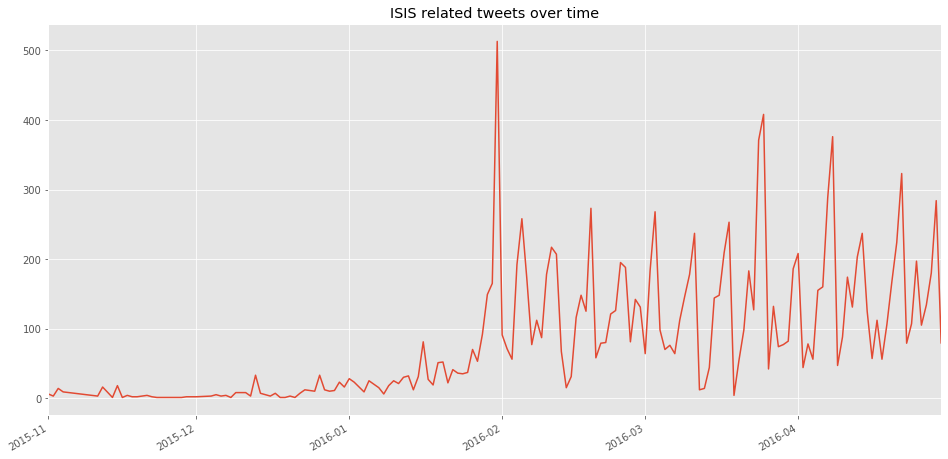

In [234]:
dataset.time.value_counts().plot(title='ISIS related tweets over time',
                              xlim=[datetime.date(2015, 11, 1),datetime.date(2016, 4, 30)],
                              figsize=(16,8))

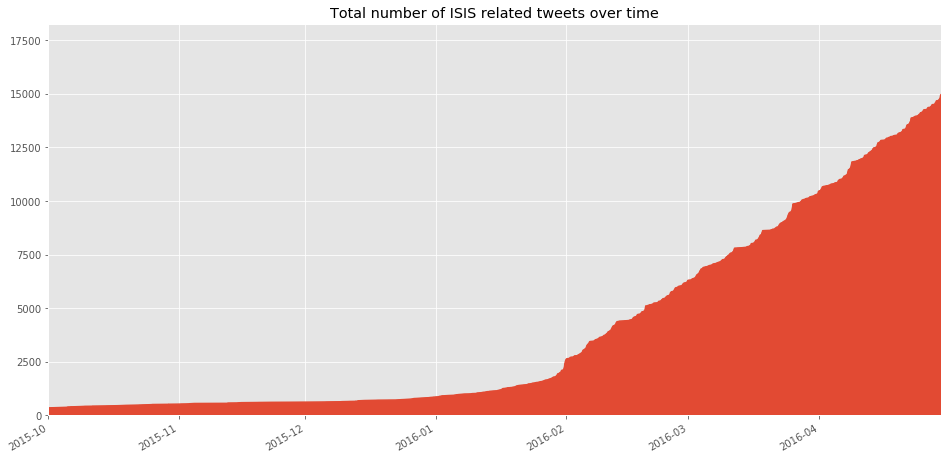

In [35]:
dataset.time.value_counts().sort_index().cumsum().plot.area(title='Total number of ISIS related tweets over time',
                                                         xlim=[datetime.date(2015, 10, 1),datetime.date(2016, 4, 30)],
                                                         figsize=(16,8))

In [36]:
time_tweets = dataset.time.value_counts().sort_index()
april_tweets = time_tweets.loc['2016-4-1':'2016-4-30']

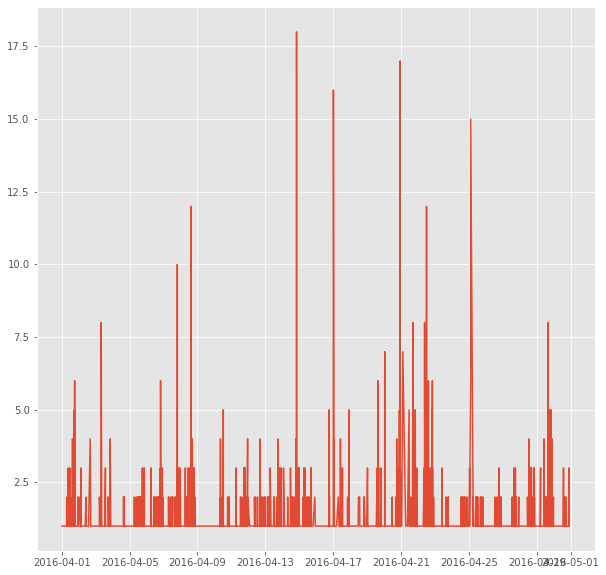

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
line = ax.plot(april_tweets)

#apr19 = 'Truck Bomb in Kabul'
#ax.annotate(apr19, xytext=('2016-4-19', 40), rotation=45,
           # arrowprops=dict(connectionstyle="arc3"), xy=('2016-4-19', 20))

#apr21 = 'Obama goes to Saudi Arabia'
#ax.annotate(apr21, xytext=('2016-4-21', 40), rotation=45,
           # arrowprops=dict(connectionstyle="arc3"), xy=('2016-4-21',20))

#apr24 = 'US Cyberattacks ISIS'
#ax.annotate(apr24, xytext=('2016-4-24', 30), rotation=45,
            #arrowprops=dict(connectionstyle="arc3"), xy=('2016-4-24', 20))

#apr27 = 'Suicide Bombing in Turkey'
#ax.annotate(apr27, xytext=('2016-4-27', 30), rotation=45,
            #arrowprops=dict(connectionstyle="arc3"), xy=('2016-4-27', 20))

#ax.set_ylim(0,50)
#plt.title('Tweets per Day and Notable Current Events in April')
plt.show()

In [137]:
MyColumns = ['hashtag','cnt']
hashtagcount = pd.DataFrame(columns=MyColumns)

for index, row in dataset.iterrows():
    if '#' in row['tweets']:
        words = row['tweets'].split()
        for word in words:
            if word[0] == '#':
                hashtagcount.loc[len(hashtagcount)] = [word, 1]  # adding a row
                
hashtags = hashtagcount.groupby(['hashtag']).count().reset_index()
hashtags = hashtags.sort_values(by='cnt').tail(10)

x = hashtags['hashtag']
y = hashtags['cnt']
plt.xlabel('hashtag')
plt.ylabel('Number of times used')
plt.title('Most number of hashtags used')
plt.xticks(range(10), x, rotation=60)
plt.bar(range(10), y, label='Most hashtags used')
plt.show()

TypeError: argument of type 'NaTType' is not iterable

In [ ]:
unique_tweeterites = dataset.groupby('username')
print(len(unique_tweeterites))

In [149]:
regex_str = [
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token.lower() for token in tokens]
    return tokens

In [151]:
hashs = dataset["tweets"].map(lambda x: [hashs for hashs in preprocess(x, lowercase=True) if hashs.startswith('#')])
hashs = sum(hashs, [])
hashs[0:5]

TypeError: expected string or bytes-like object

In [50]:
graph = nx.Graph()
graph.add_nodes_from(user_count.keys())

edges = {}
occurrence_count = Counter(map(tuple, in_set))
for (sender, receiver), count in occurrence_count.items():
    #print("Sender: {} Receiver: {} Count: {}".format(sender, receiver, count))
    if (receiver, sender) in edges.keys():
        edges[(receiver, sender)] = edges[(receiver, sender)] + count
    else:
        edges[(sender, receiver)] = count

for (sender, receiver), count in edges.items():
    graph.add_edge(sender, receiver, weight=count)

plt.figure(figsize=(12,12))
nx.draw(graph, pos=nx.spring_layout(graph), node_size = [size*100 for key, size in user_count.items()],
       with_labels=True)
print(user_count.keys())
plt.show()

NameError: name 'user_count' is not defined

In [51]:
user_count = Counter(in_set[:,1])
top_5 = user_count.most_common(5)
print(top_5)

[('RamiAlLolah', 53), ('Nidalgazaui', 34), ('MilkSheikh2', 26), ('WarReporter1', 15), ('_IshfaqAhmad', 15)]


dict_keys(['mobi_ayubi', 'Nidalgazaui', 'ismailmahsud', 'RamiAlLolah', 'QassamiMarwan', 'AbuNaseeha_03', 'MaghrebiQM', 'MaghrabiArabi', 'warrnews', 'ManKhalfahum', 'ansarakhilafa', 'darulhijrateyni', 'Uncle_SamCoco', 'mustaklash', '1515Ummah', 'WarReporter1', 'mustafaklash56', 'FidaeeFulaani', '_IshfaqAhmad', 'MilkSheikh2', 'abuhumayra4', 'klakishinki', 'abuayisha102', '432Mryam', 'AsimAbuMerjem', 'EPlC24', 'MaghrebiHD', 'Freedom_speech2', 'thefIamesofhaqq', 'Jazrawi_Joulan', 'Mosul_05', 'MaghrebiQ', 'Jazrawi_Saraqib', 'MaghrebiWM', '__alfresco__', 'Suspend_Me_fags', 'murasil1', 'AbuMusab_110', 'st3erer', 'kIakishini5', 'lNSlDEWAR'])


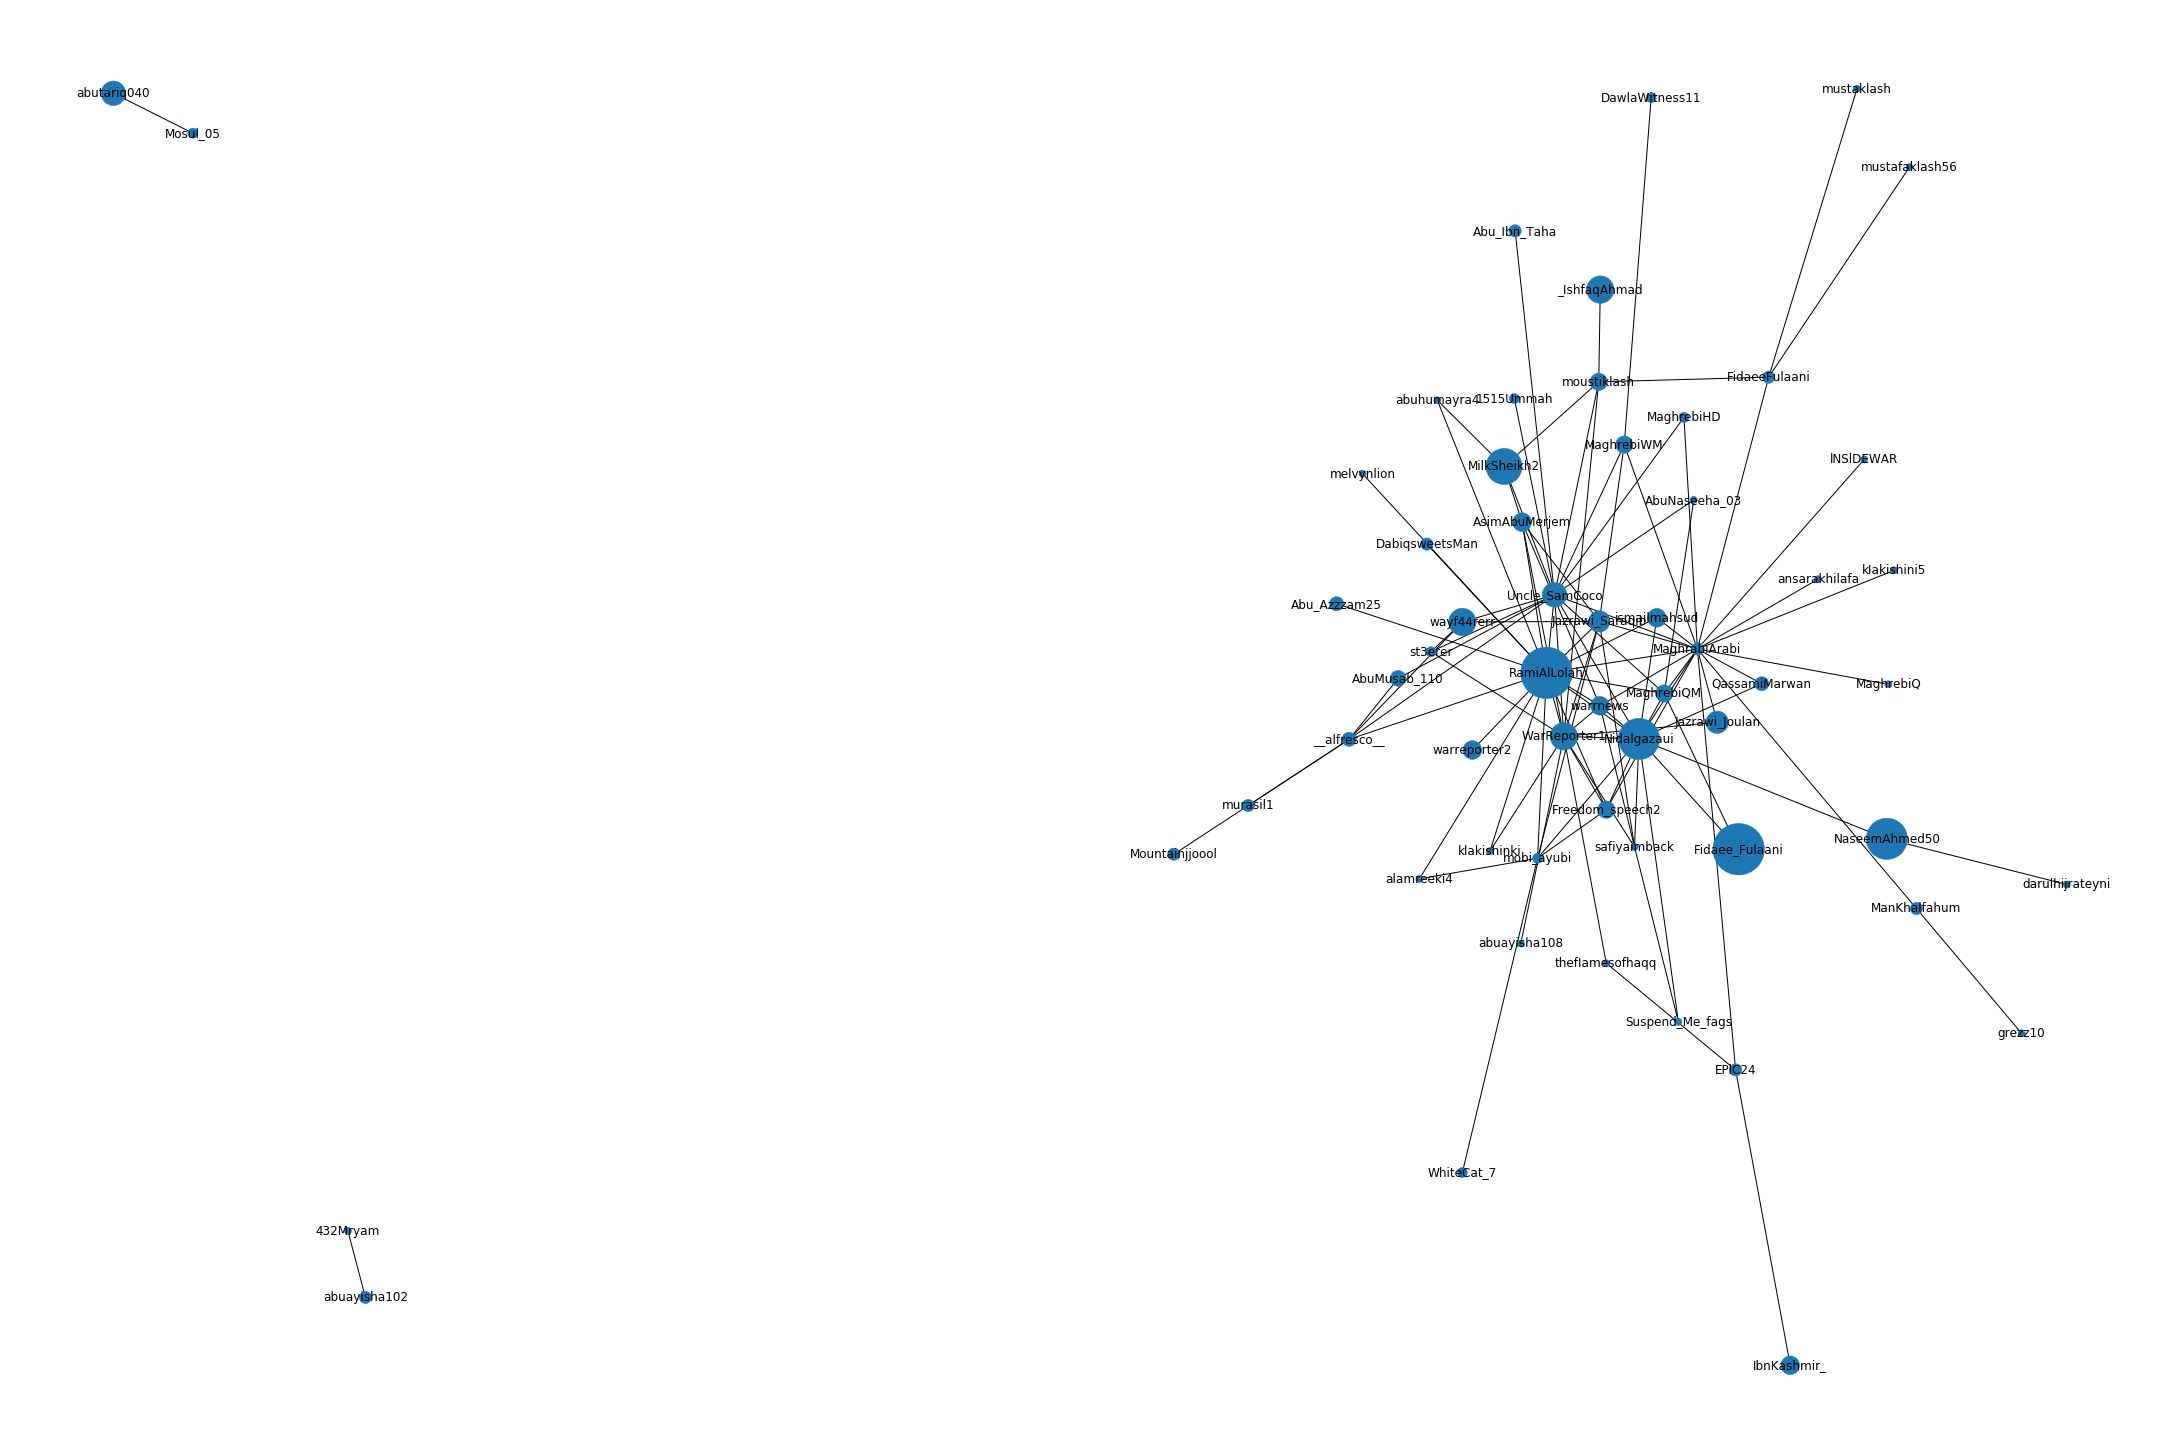

In [90]:
graph = nx.Graph()
graph.add_nodes_from(user_count.keys())

edges = {}
occurrence_count = Counter(map(tuple, in_set))
for (sender, receiver), count in occurrence_count.items():
    #print("Sender: {} Receiver: {} Count: {}".format(sender, receiver, count))
    if (receiver, sender) in edges.keys():
        edges[(receiver, sender)] = edges[(receiver, sender)] + count
    else:
        edges[(sender, receiver)] = count

for (sender, receiver), count in edges.items():
    graph.add_edge(sender, receiver, weight=count)

plt.figure(figsize=(30,20))
nx.draw(graph, pos=nx.spring_layout(graph), node_size = [size*50 for key, size in user_count.items()],
       with_labels=True)
print(user_count.keys())
plt.show()